In [3]:
!pip install imutils
import numpy as np
import pandas as pd
import os
import random
import cv2
import imutils
import random
from sklearn import svm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=a296c19b727d1f98221b2f21038853347bc658b0ce002eda14093736d39378bf
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Pre-Processing

In [4]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#", "$", "&", "@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        train_data.append([img, i])

In [5]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        val_data.append([img, i])

In [6]:
random.shuffle(train_data)
random.shuffle(val_data)

train_X = []
train_Y = []
for features, label in train_data:
    train_X.append(features)
    train_Y.append(label)

val_X = []
val_Y = []
for features, label in val_data:
    val_X.append(features)
    val_Y.append(label)
    
Train_X = train_X[:]
Train_Y = train_Y[:]
Val_X = val_X[:]
Val_Y = val_Y[:]

# Feature Extraction

In [7]:
# Extract features from images
n_samples = len(train_X)
n_features = img_size * img_size
train_X = np.array(train_X).reshape(n_samples, -1)

n_samples_val = len(val_X)
val_X = np.array(val_X).reshape(n_samples_val, -1)

# Scale the data
n_components = 64  # Adjust the number of components as needed
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

# Training SVM model

In [8]:
# SVM model
svm_model = svm.SVC(kernel='linear', C=1.0)

# Train the SVM
svm_model.fit(train_X, train_Y)

# Make predictions on the validation set
val_Y_pred = svm_model.predict(val_X)

# Evaluate the SVM model
accuracy = accuracy_score(val_Y, val_Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.74%


In [9]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [10]:
loaded_model = pickle.load(open(filename, 'rb'))

# Testing on characters

['4']


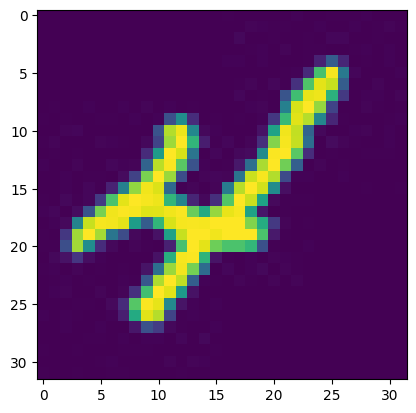

In [11]:
import cv2
import numpy as np

# Load and preprocess the test image
test_image_path = '/kaggle/input/handwritten-characters/Validation/4/0.jpg'
img = cv2.imread(test_image_path, 0)  # Load the image in grayscale
plt.imshow(img)
img = cv2.resize(img, (img_size, img_size))  # Resize to the same dimensions as training data

# Flatten the image into a 1D array
img_flat = img.reshape(-1)

# If necessary, apply the same preprocessing as you did for training data, such as PCA transformation or normalization.
img_transformed = pca.transform([img_flat])  # If you applied PCA transformation

# Make predictions using the SVM model
predn = svm_model.predict(img_transformed)
print(predn)

['2']


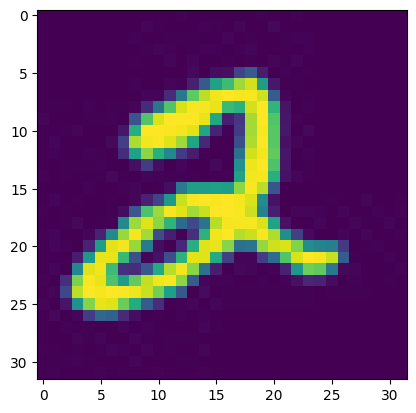

In [12]:
import cv2
import numpy as np

# Load and preprocess the test image
test_image_path = '/kaggle/input/handwritten-characters/Validation/2/0.jpg'
img = cv2.imread(test_image_path, 0)  # Load the image in grayscale

img = cv2.resize(img, (img_size, img_size))  # Resize to the same dimensions as training data
plt.imshow(img)
# Flatten the image into a 1D array
img_flat = img.reshape(-1)

# If necessary, apply the same preprocessing as you did for training data, such as PCA transformation or normalization.
img_transformed = pca.transform([img_flat])  # If you applied PCA transformation

# Make predictions using the SVM model
predn = svm_model.predict(img_transformed)
print(predn)

In [13]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Grapheme segmentation

In [14]:
import cv2
import imutils
import numpy as np

def grapheme_segmentation(img):
    graphemes = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            graphemes.append(roi)
    
    return graphemes, image

In [15]:
def recognize_characters(graphemes, svm_model, pca, img_size):
    letters = []
    
    for roi in graphemes:
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        img_flat = thresh.reshape(-1)
        thresh = pca.transform([img_flat])
        ypred = svm_model.predict(thresh)
        letters.append(ypred[0])
    
    return letters

In [16]:
def get_word(letter):
    word = "".join(letter)
    return word

Recognized Word: CMFBP14Q


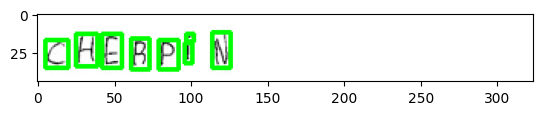

In [17]:
img_size = 32

img_path = '/kaggle/input/handwriting-recognition/test_v2/test/TEST_0005.jpg'

graphemes, image = grapheme_segmentation(img_path)
letters = recognize_characters(graphemes, svm_model, pca, img_size)
word = get_word(letters)
print("Recognized Word:", word)
plt.imshow(image)

# K-Means Clustering

In [ ]:
from sklearn.neighbors import NearestNeighbors

n_clusters = 40

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(train_X)
nn_model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(kmeans.cluster_centers_)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
correct_predictions = 0
total_samples = len(val_X)

for i in range(total_samples):
    nearest_cluster_index = nn_model.kneighbors(val_X, n_neighbors=1)[1][0][0]
    
    predicted_character = train_Y[np.where(kmeans.labels_ == nearest_cluster_index)[0][0]]
    
    if predicted_character == val_Y[i]:
        correct_predictions += 1
accuracy = (correct_predictions / total_samples) * 30
print(f"Accuracy using Nearest Neighbors with K-means: {accuracy*100:.2f}%")

KeyboardInterrupt: 

# Phase-2

**Step1** : Build a digit(0-9) + A-Z characters classifier using a CNN architecture. 

**Step2**: Apply character segmentation for the handwritten word image.

**Step3**: Classify each segmented letter and then get the final word in the image.

In [20]:
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [21]:
LB = LabelBinarizer()
Train_Y = LB.fit_transform(Train_Y)
Val_Y = LB.fit_transform(Val_Y)

In [22]:
print(len(Train_X),len(Val_X))
print(Train_Y.size,Val_Y.size)

140000 15209
4900000 532315


In [23]:
Train_X = np.array(Train_X)/255.0
Train_X = Train_X.reshape(-1,32,32,1)
Train_Y = np.array(Train_Y)

In [24]:
Val_X = np.array(Val_X)/255.0
Val_X = Val_X.reshape(-1,32,32,1)
Val_Y = np.array(Val_Y)

In [25]:
print(Train_X.shape,Val_X.shape)
print(Train_Y.shape,Val_Y.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)
(140000, 35) (15209, 35)


In [26]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [28]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [29]:
history = model.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X, Val_Y),  verbose=1)

Epoch 1/20


2023-11-28 08:54:53.451604: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4375/4375 [==============================] - 30s 4ms/step - loss: 0.6110 - accuracy: 0.8050 - val_loss: 0.3389 - val_accuracy: 0.8962
Epoch 2/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3417 - accuracy: 0.8839 - val_loss: 0.2624 - val_accuracy: 0.9129
Epoch 3/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2994 - accuracy: 0.8971 - val_loss: 0.2394 - val_accuracy: 0.9235
Epoch 4/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2764 - accuracy: 0.9039 - val_loss: 0.2616 - val_accuracy: 0.9000
Epoch 5/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2583 - accuracy: 0.9110 - val_loss: 0.2438 - val_accuracy: 0.9150
Epoch 6/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2445 - accuracy: 0.9143 - val_loss: 0.2462 - val_accuracy: 0.9164
Epoch 7/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2349 - accuracy: 0.9165 - val_loss: 0.2324 - val_accuracy: 0.9

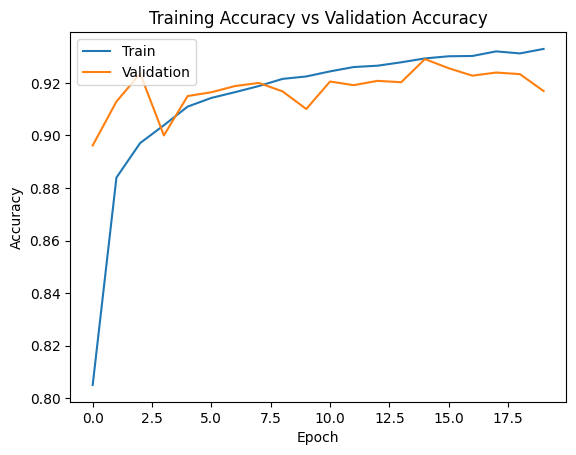

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

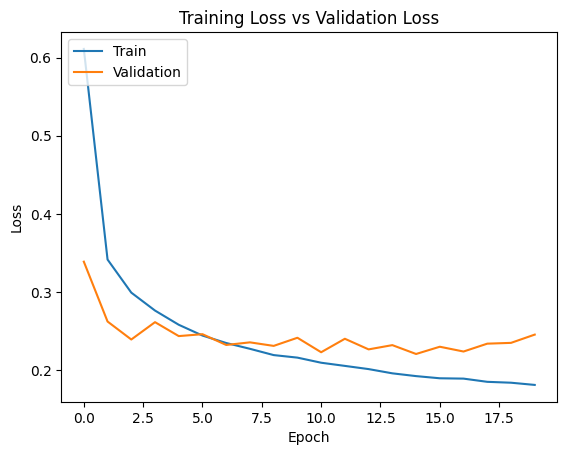

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

1/1 [==============================] - 0s 20ms/step
BENFS


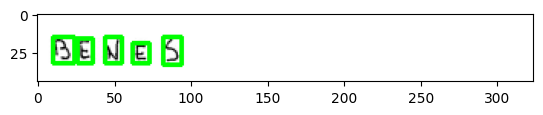

In [34]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 19ms/step
JAFFFLX


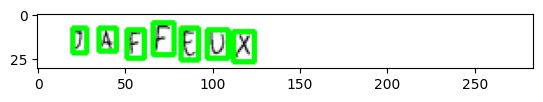

In [35]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
import tensorflow_hub as hub
from sklearn.ensemble import BaggingClassifier
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.shortcut = tf.keras.Sequential()
        if stride != 1:
            self.shortcut.add(tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=stride, use_bias=False))
            self.shortcut.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += self.shortcut(residual)
        x = self.relu(x)
        return x


In [40]:
class ResNetOCR(tf.keras.Model):
    def __init__(self, num_classes=35):
        super(ResNetOCR, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32, 32, 1), use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)

        self.global_avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, stride=1))
        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)

        x = self.global_avgpool(x)
        x = self.fc(x)

        return x

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices((Train_X, Train_Y))
val_dataset = tf.data.Dataset.from_tensor_slices((Val_X, Val_Y))

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=140000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

mod2 = ResNetOCR(num_classes=35)

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mod2.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [45]:
num_epochs = 20
history2 = mod2.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

mod2.save_weights('resnet_ocr_tf.h5')

Epoch 1/20
2188/2188 [==============================] - 39s 12ms/step - loss: 0.3844 - accuracy: 0.8712 - val_loss: 0.4032 - val_accuracy: 0.8646
Epoch 2/20
2188/2188 [==============================] - 30s 12ms/step - loss: 0.2562 - accuracy: 0.9102 - val_loss: 0.3082 - val_accuracy: 0.8990
Epoch 3/20
2188/2188 [==============================] - 29s 12ms/step - loss: 0.2235 - accuracy: 0.9211 - val_loss: 0.3334 - val_accuracy: 0.8813
Epoch 4/20
2188/2188 [==============================] - 29s 12ms/step - loss: 0.2032 - accuracy: 0.9271 - val_loss: 0.3069 - val_accuracy: 0.8920
Epoch 5/20
2188/2188 [==============================] - 29s 12ms/step - loss: 0.1844 - accuracy: 0.9322 - val_loss: 0.2486 - val_accuracy: 0.9135
Epoch 6/20
2188/2188 [==============================] - 29s 12ms/step - loss: 0.1701 - accuracy: 0.9371 - val_loss: 0.2880 - val_accuracy: 0.8978
Epoch 7/20
2188/2188 [==============================] - 29s 12ms/step - loss: 0.1577 - accuracy: 0.9408 - val_loss: 0.2515 -

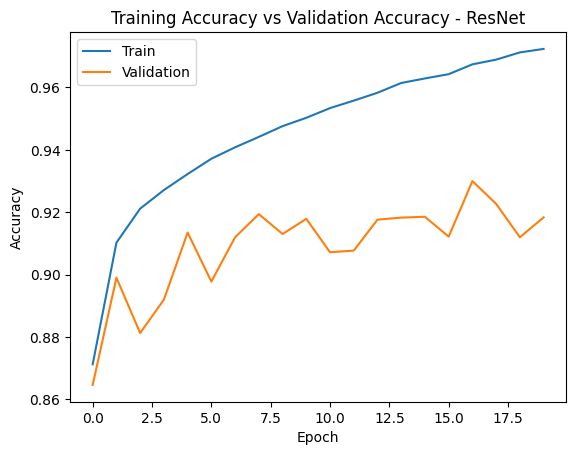

In [48]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

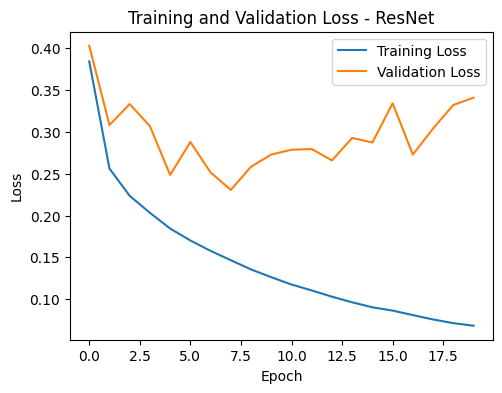

In [51]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

1/1 [==============================] - 0s 31ms/step
LAMHTDJWE


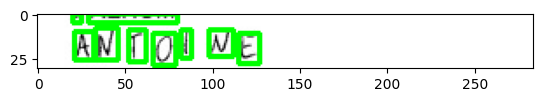

In [53]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0016.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)